# Vehicle Detection and Tracking Project 

Overall goal: To write a software pipeline to detect vehicles in the attached test video (.mp4)

The breakdown goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

# Import

In [82]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import time
from collections import deque
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

print('Import Completed')

Import Completed


# Load Training Dataset

In [3]:
# read cars and notcars
car_images = glob.glob('dataset/vehicles/**/*.png')
notcar_images = glob.glob('dataset/non-vehicles/**/*.png')
print("Number of cars image =", len(car_images))
print("Number of notcars image =", len(notcar_images))

Number of cars image = 8792
Number of notcars image = 8968


# Visualization of the dataset

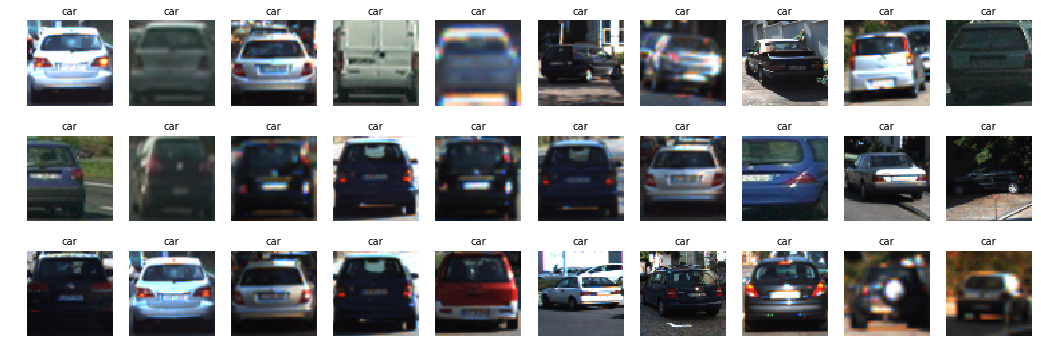

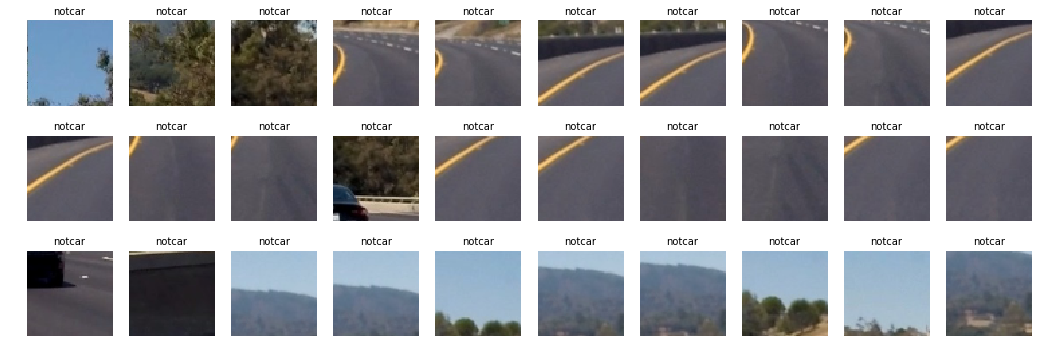

In [4]:
def show_sample_images(image_list, title):
    image_count = len(image_list)
    rows, cols = image_count//10, 10
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6))
    for idx, ax in enumerate(axes.flatten()):
        if idx < image_count:
            ax.set_title(title, fontsize=10)
            ax.imshow(mpimg.imread(image_list[idx]))
        ax.axis('off')
        
np.random.shuffle(car_images)
show_sample_images(car_images[:30], 'car')
show_sample_images(notcar_images[:30], 'notcar')

# Convert Image to Histogram of Oriented Gradients (HOG)
Referenced code from the lesson: HOG Classify.

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
print('HOG Feature Extraction Define Completed')

HOG Feature Extraction Define Completed


Here are some random examples of visualizing HOG feature extraction from the car and noncar image:


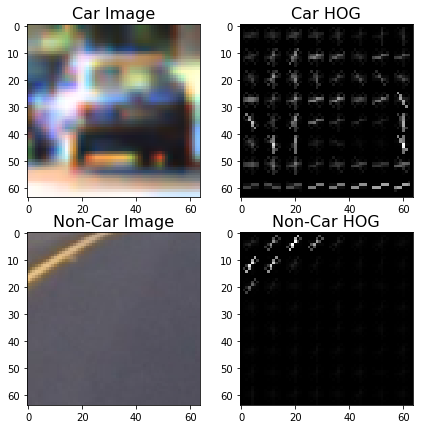

In [83]:
rand_idx = np.random.randint(0, 100) #random pick examples
car_img = mpimg.imread(car_images[rand_idx])
_, car_hog = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
notcar_img = mpimg.imread(notcar_images[rand_idx])
_, notcar_hog = get_hog_features(notcar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_hog, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(notcar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(notcar_hog, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

print('Here are some random examples of visualizing HOG feature extraction from the car and noncar image:')

# Extract Features from a list of images
Define a method to extract features from an array of Car and Non-Car Images. 
Referenced code from the lesson: Color & HOG Classify.

In [84]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      
            
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

print('Define Feature Extraction Function Completed')

Define Feature Extraction Function Completed


# Extract Feature and Split Data

In [14]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"


t=time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

76.74 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


# Train The Classifier

In [15]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

7.47 Seconds to train SVC...
Test Accuracy of SVC =  0.9876
My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
0.00798 Seconds to predict 10 labels with SVC


# Using The Classifier to Detect Cars in an Image
Define a method to use the trained classifier to dected cars in an image.
Referenced code from the lesson.

In [85]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, search_all_rectangles=False):
    
    rectangles = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
#     nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
#     nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1    
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
    
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            
            test_features = X_scaler.transform(test_features)
            test_prediction = svc.predict(test_features)

            if test_prediction == 1 or search_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

print('Find Car Function Define Completed')

Find Car Function Define Completed


# Test the Find Car Function on an Example Image

In [86]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 380
ystop = 656
scale = 1.5
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

print(len(rectangles), 'rectangles found in a image')

9 rectangles found in a image


# Draw The Detected Rectangles Back on Image
Referenced code from the lesson.

In [87]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=4):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

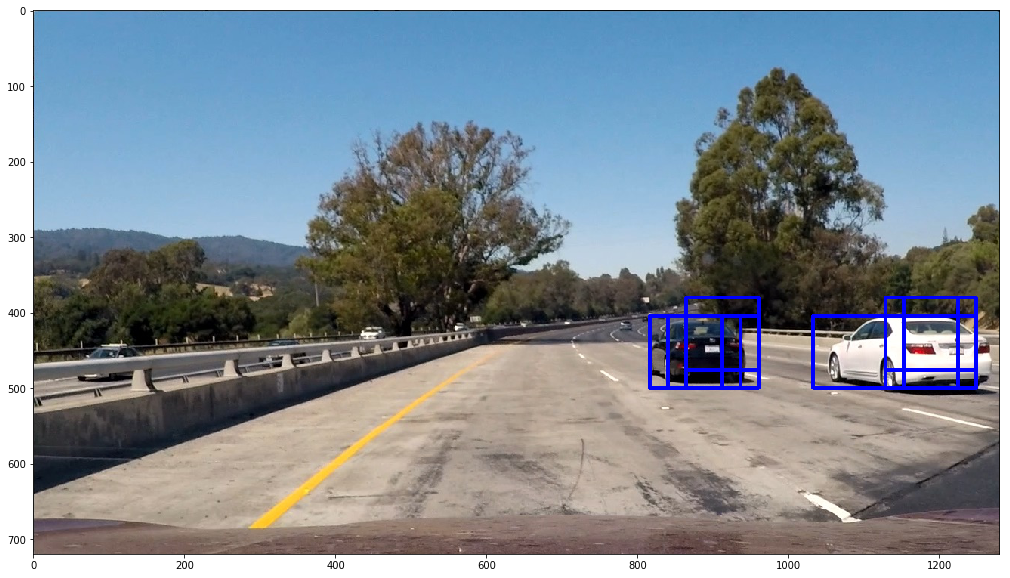

In [49]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(18,10))
plt.imshow(test_img_rects)

# Show All Potential Search Areas
Due to the size and position of cars in the image will be different depending on their distance from the camera, find_cars will adopt different parameters which include ystart, ystop, and scale values to fit them. These next few blocks of code are for determining the values for these parameters that work best.

# Set Scale to 1.0

Number of boxes:  385


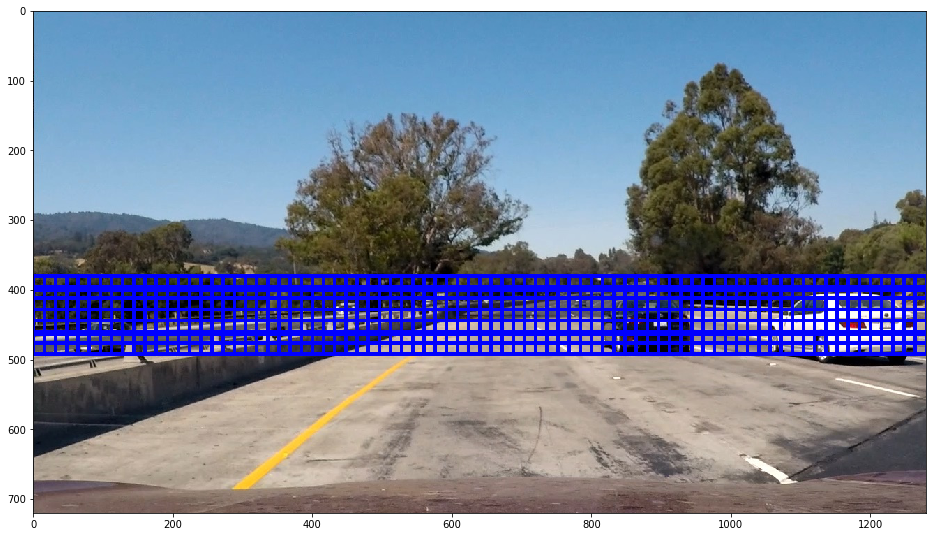

In [51]:
rectangles = []

ystart = 400
ystop = 464
scale = 1.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

ystart = 380
ystop = 496
scale = 1.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))


test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(16, 10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

# Set Scale to 1.5

Number of boxes:  300


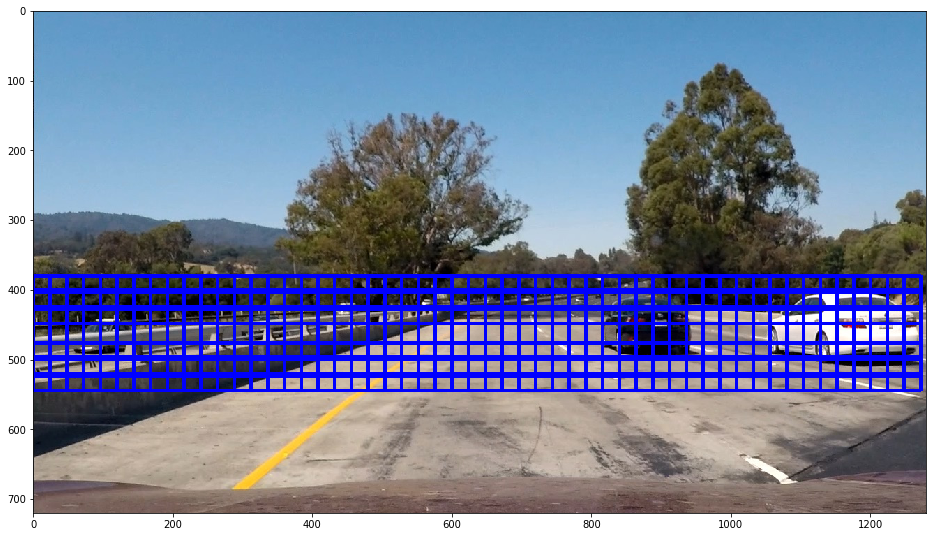

In [52]:
rectangles = []

ystart = 380
ystop = 528
scale = 1.5
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

ystart = 400
ystop = 548
scale = 1.5
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(16,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

# Set Scale to 2.0

Number of boxes:  74


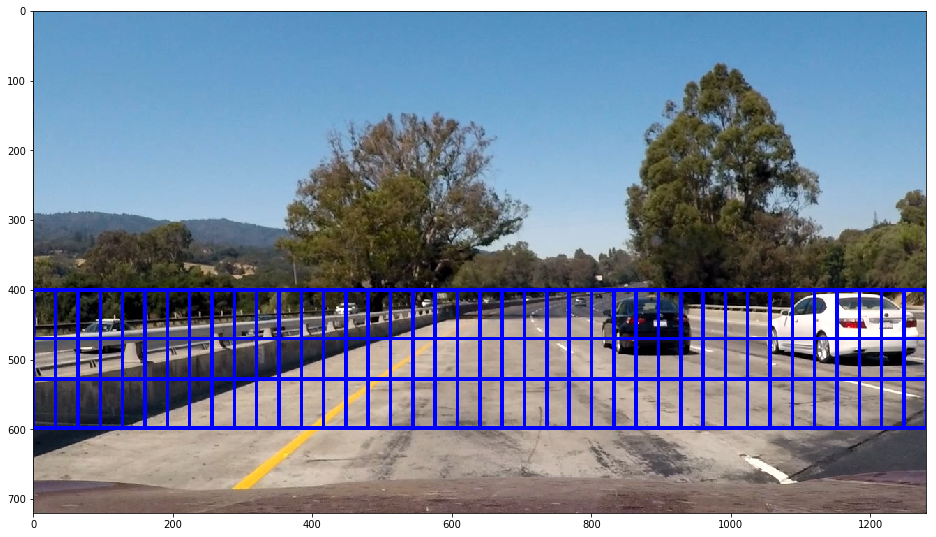

In [53]:
rectangles = []

ystart = 400
ystop = 528
scale = 2.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

ystart = 470
ystop = 598
scale = 2.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(16,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

# Set Scale to 3.0

Number of boxes:  46


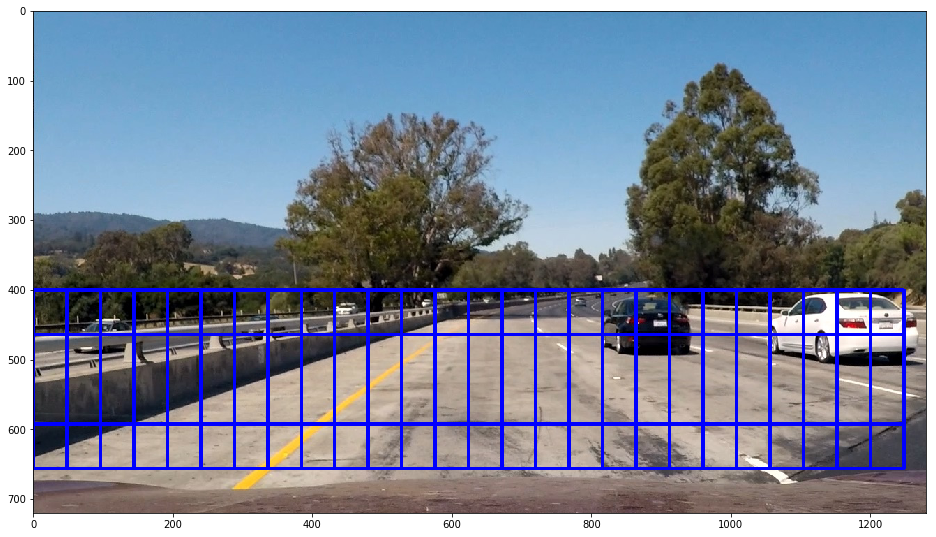

In [54]:
rectangles = []

ystart = 400
ystop = 596
scale = 3.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

ystart = 464
ystop = 660
scale = 3.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(16,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

# Combine All Sliding Window Searches

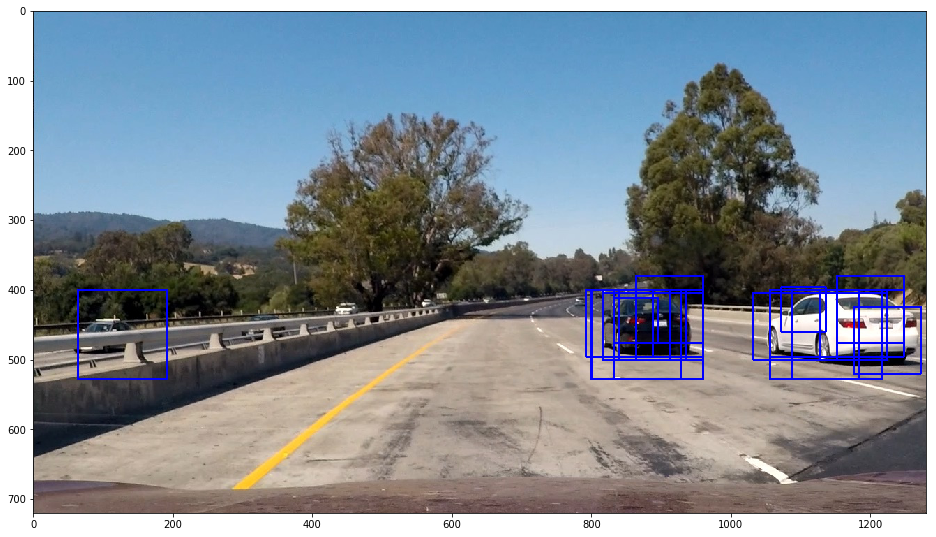

In [97]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

ystart = 400
ystop = 464
scale = 1.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
ystart = 380
ystop = 496
scale = 1.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))

ystart = 380
ystop = 528
scale = 1.5
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
ystart = 400
ystop = 548
scale = 1.5
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
ystart = 400
ystop = 528
scale = 2.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
ystart = 470
ystop = 598
scale = 2.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
ystart = 400
ystop = 596
scale = 3.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
ystart = 464
ystop = 660
scale = 3.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))


test_img_rects = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(16,10))
plt.imshow(test_img_rects)

# Heatmap
Create a heat-map from these detections in order to combine overlapping detections and remove false positives.
Referenced code from the lesson. 

In [98]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('Add Heat Function Define Completed')

Add Heat Completed


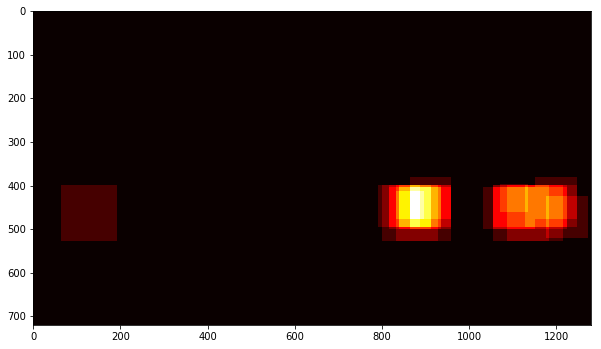

In [99]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

# Apply Threshold to Reject the Flase Positives
Imposing a threshold to reject areas affected by false positives.

In [100]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('Apply Threshold Define Completed')

Apply Threshold Define Completed


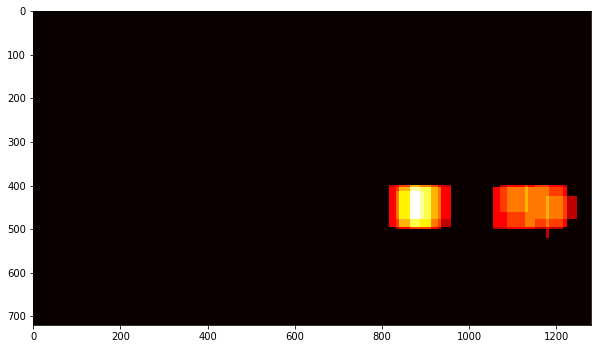

In [101]:
heatmap_img = apply_threshold(heatmap_img, 2)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

# Apply SciPy Labels to Heatmap
Once obtaining the thresholded heat-map from a list of bounding boxes, use the label() function from scipy.ndimage.measurements.  to figure out how many cars in each frame and which pixels belong to which car.

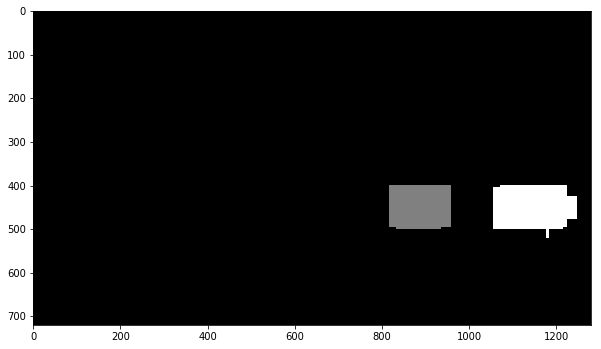

In [67]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')

# Draw Bounding Boxes for Lables
Take the labels image and put bounding boxes around the labeled regions. Referenced code from the lesson.

In [102]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

print('Draw Labeled Bounding Boxes Function Define Completed')

Draw Labeled Bounding Boxes Function Define Completed


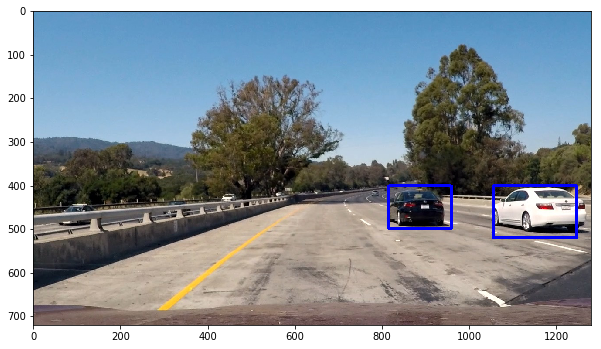

In [69]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

# Put Them All Together
Create a bounding box drawing pipeline to process every frame.
Please note that this pipeline only processes a frame at a time without accounting for information from previous frames.

In [103]:
def process_frame(img):

    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32, 32)
    hist_bins = 32
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 380
    ystop = 496
    scale = 1.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))

    ystart = 380
    ystop = 528
    scale = 1.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 548
    scale = 1.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 470
    ystop = 598
    scale = 2.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 596
    scale = 3.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 464
    ystop = 660
    scale = 3.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 2)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

print('Bounding Box Drawing Pipeline Define Completed')

Bounding Box Drawing Pipeline Define Completed


# Run The Pipeline on All Test Images
To ensure the pipeline works before applying to the video.


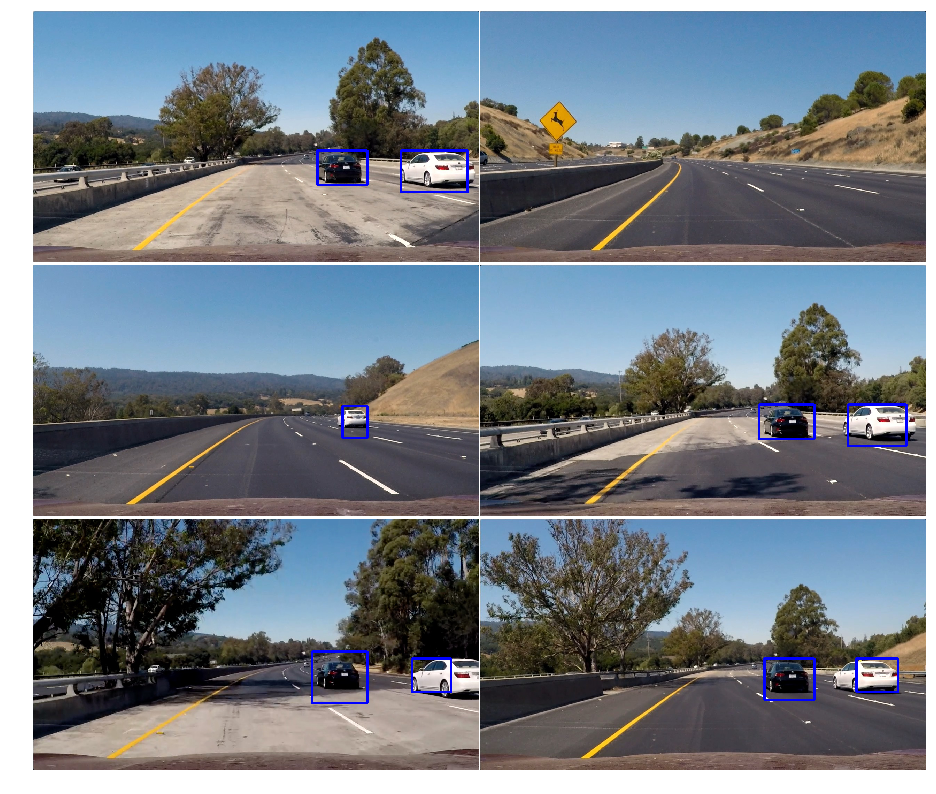

In [73]:
test_imgs = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_imgs):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

# Run The Pipeline on a Short Test Video
Process a test video with pipeline, confirm the result before applying the pipleline to the full project video.
Please note that this pipeline only processes a frame at a time without accounting for information from previous frames.

In [74]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|████████████████████████████████████████████████████████████████████████████████████████████▌  | 38/39 [00:41<00:01,  1.07s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 42.4 s


# Define a Class to Store Data from Vehicle Detections
To improve the pipeline for processing video, need to have the pipeline processes each frame while accounting/tracking for information from previous frames.

In [75]:
class Vehicle_Detect(object):
    def __init__(self, n):
        # hold the detection rectangles of previous n frames
        self.prev_rects = deque(maxlen=n)
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)

In [104]:
def process_frame_from_video(img):

    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32, 32)
    hist_bins = 32
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 380
    ystop = 496
    scale = 1.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))

    ystart = 380
    ystop = 528
    scale = 1.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 548
    scale = 1.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 470
    ystop = 598
    scale = 2.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 596
    scale = 3.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 464
    ystop = 660
    scale = 3.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    
    if len(rectangles) > 0:
        veh.add_rects(rectangles)
        
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in veh.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)  
    heatmap_img = apply_threshold(heatmap_img, 1 + len(veh.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

print('Improved Pipeline Define Completed')

Improved Pipeline Define Completed


In [77]:
veh = Vehicle_Detect(20)
test_out_file2 = 'test_video_out2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_from_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out2.mp4
[MoviePy] Writing video test_video_out2.mp4


 97%|████████████████████████████████████████████████████████████████████████████████████████████▌  | 38/39 [00:41<00:01,  1.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out2.mp4 

Wall time: 43.1 s


# Run The Pipeline on The Project Video
Apply the pipeline on the full project video.

In [81]:
veh = Vehicle_Detect(20)

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4')
clip_proj_out = clip_proj.fl_image(process_frame_from_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



  5%|████▍                                                                                        | 60/1261 [01:04<21:28,  1.07s/it]


 10%|████████▊                                                                                   | 121/1261 [02:09<20:18,  1.07s/it]


 14%|█████████████▎                                                                              | 182/1261 [03:15<19:24,  1.08s/it]


 19%|█████████████████▋                                                                          | 243/1261 [04:21<18:05,  1.07s/it]


 24%|██████████████████████▏                                                                     | 304/1261 [05:26<17:00,  1.07s/it]


 29%|██████████████████████████▋                                                                 | 365/1261 [06:32<16:32,  1.11s/it]


 34%|███████████████████████████████                                                             | 426/1261 [07:40<15:17,  1.10s/it]


 39%|███████████████████████████████████▌                                                        | 487/1261 [08:48<14:00,  1.09s/it]


 43%|███████████████████████████████████████▉                                                    | 548/1261 [09:55<13:10,  1.11s/it]


 48%|████████████████████████████████████████████▍                                               | 609/1261 [11:03<12:17,  1.13s/it]


 53%|████████████████████████████████████████████████▉                                           | 670/1261 [12:11<10:29,  1.07s/it]


 58%|█████████████████████████████████████████████████████▎                                      | 731/1261 [13:15<09:21,  1.06s/it]


 63%|█████████████████████████████████████████████████████████▊                                  | 792/1261 [14:21<08:19,  1.06s/it]


 68%|██████████████████████████████████████████████████████████████▏                             | 853/1261 [15:25<07:12,  1.06s/it]


 72%|██████████████████████████████████████████████████████████████████▋                         | 914/1261 [16:30<06:08,  1.06s/it]


 77%|███████████████████████████████████████████████████████████████████████▏                    | 975/1261 [17:35<05:05,  1.07s/it]


 82%|██████████████████████████████████████████████████████████████████████████▊                | 1036/1261 [18:41<03:59,  1.06s/it]


 87%|███████████████████████████████████████████████████████████████████████████████▏           | 1097/1261 [19:46<02:55,  1.07s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 1158/1261 [20:50<01:49,  1.06s/it]


 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 1219/1261 [21:55<00:44,  1.07s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [22:39<00:01,  1.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 22min 40s
